<a href="https://colab.research.google.com/github/DrKamaleshR/DL-FER/blob/main/DL_FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install deepface

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.7 MB/s 
     |████████████████████████████████| 87 kB 7.5 MB/s 
     |████████████████████████████████| 2.3 MB 54.2 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=ef76447f8783b294be023947d9fb04b374030040788020aa9fcc470e8d8525cb
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%matplotlib inline 
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential #Initialise our neural network model as a sequential network
from keras.layers import Conv2D #Convolution operation
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.layers import Activation#Applies activation function
from keras.layers import Dropout#Prevents overfitting by randomly converting few outputs to zero
from keras.layers import MaxPooling2D # Maxpooling function
from keras.layers import Flatten # Converting 2D arrays into a 1D linear vector
from keras.layers import Dense # Regular fully connected neural network
from tensorflow.keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score


In [128]:
def load_data(dataset_path): #Run once
  
  #classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprsie', 'Neutral']  #We will be dealing with seven different types of emotions.

  data = []
  test_data = []
  test_labels = []
  labels =[]

  with open(dataset_path, 'r') as file:
      for line_no, line in enumerate(file.readlines()):
          if 0 < line_no <= 35887:
            curr_class, line, set_type = line.split(',')
            image_data = np.asarray([int(x) for x in line.split()]).reshape(48, 48)#Creating a list out of the string then converting it into a 2-Dimensional numpy array.
            image_data =image_data.astype(np.uint8)/255.0
            
            if (set_type.strip() == 'PrivateTest'):
              
              test_data.append(image_data)
              test_labels.append(curr_class)
            else:
              data.append(image_data)
              labels.append(curr_class)
      
      test_data = np.expand_dims(test_data, -1)
      test_labels = to_categorical(test_labels, num_classes = 7)
      data = np.expand_dims(data, -1)   
      labels = to_categorical(labels, num_classes = 7)
    
      return np.array(data), np.array(labels), np.array(test_data), np.array(test_labels)


In [125]:
dataset_path = "/content/drive/MyDrive/almabetter projects/DL-FER/fer2013.csv" 
train_data, train_labels, test_data, test_labels = load_data(dataset_path)
#train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = test_size,random_state = seed)

print("Number of images in Training set:", len(train_data))
print("Number of images in Test set:", len(test_data))

Number of images in Training set: 32298
Number of images in Test set: 3589


1.ADAM model

In [129]:
epochs = 75
batch_size = 64
learning_rate = 0.001
#################################

model = Sequential()
    
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1), kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

adam = optimizers.Adam(lr = learning_rate)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
print(model.summary())

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)
early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=6, mode='auto')
checkpointer = ModelCheckpoint('/content/drive/MyDrive/almabetter projects/DL-FER/model(1).h5', monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(
          train_data,
          train_labels,
          epochs = epochs,
          batch_size = batch_size,
          validation_split = 0.2,
          shuffle = True
          )

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 conv2d_56 (Conv2D)          (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_50 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 23, 23, 64)        0         
                                                                 
 conv2d_57 (Conv2D)          (None, 23, 23, 128)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Trainable params: 9,009,223
Non-trainable params: 5,504
_________________________________________________________________
None
Epoch 1/75
404/404 [==============================] - 28s 67ms/step - loss: 2.1017 - accuracy: 0.2008 - val_loss: 1.8625 - val_accuracy: 0.2464
Epoch 2/75
404/404 [==============================] - 27s 66ms/step - loss: 1.8587 - accuracy: 0.2402 - val_loss: 1.8460 - val_accuracy: 0.2464
Epoch 3/75
404/404 [==============================] - 27s 66ms/step - loss: 1.8460 - accuracy: 0.2468 - val_loss: 1.8252 - val_accuracy: 0.2464
Epoch 4/75
404/404 [==============================] - 27s 66ms/step - loss: 1.8310 - accuracy: 0.2499 - val_loss: 1.8178 - val_accuracy: 0.2464
Epoch 5/75
404/404 [==============================] - 27s 66ms/step - loss: 1.8236 - accuracy: 0.2505 - val_loss: 1.8132 - val_accuracy: 0.2464
Epoch 6/75
404/404 [==============================] - 27s 66ms/step - loss: 1.8204 - accuracy: 0.2505 - val_loss: 1.8113 - val_accuracy: 0.2464
Epoch 7/7

### **Evaluation Metrics**

In [130]:
#checking accuracy
predicted_test_labels = np.argmax(model.predict(test_data), axis=1)
test_labels = np.argmax(test_labels, axis=1)
print ("Accuracy score = ", accuracy_score(test_labels, predicted_test_labels))
print ("Accuracy percentage = ", accuracy_score(test_labels, predicted_test_labels)*100, "%")

AxisError: ignored

In [76]:
labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [77]:
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    plt.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    # ax.set_title('Confusion Matrix')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [78]:
plot_confusion_matrix(test_labels, predicted_test_labels, cmap=plt.cm.YlGnBu)
plt.show()

TypeError: ignored

## **Classification** **report**

In [79]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted_test_labels, target_names=labels))

TypeError: ignored

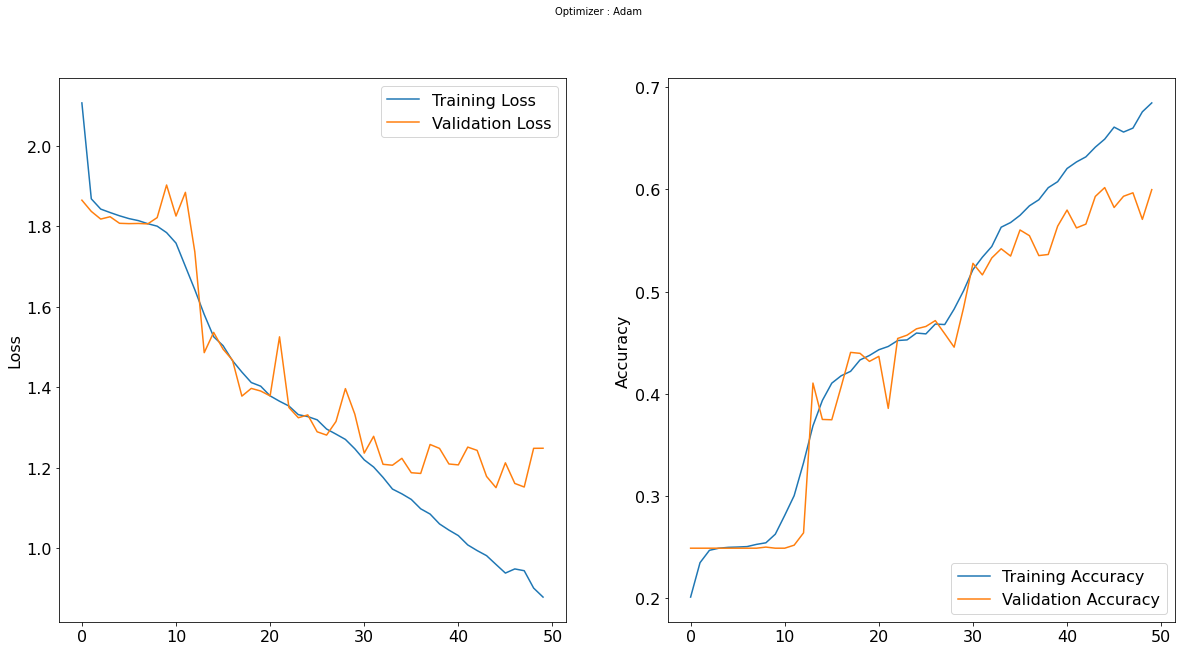

In [14]:
#Loss accuracy Graph
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

## **Saving** **of** **Model**

In [32]:
from keras.models import model_from_json
model_json = model.to_json()
with open("/content/drive/MyDrive/almabetter projects/DL-FER/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/almabetter projects/DL-FER/model.hdf5")
print("Saved model to disk")

Saved model to disk


In [34]:
# Saving the whole model along with architecture in FER_model.h5
model.save('/content/drive/MyDrive/almabetter projects/DL-FER/FER_model.h5')
print('Model Saved')

Model Saved


In [26]:
import keras

In [35]:
saveBestModel = keras.callbacks.ModelCheckpoint('/best_model.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1,save_freq='epoch')

## To Check our Model

In [36]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [42]:
#model loading
from keras.models import model_from_json
import numpy as np
import cv2

def load_model(path):

	json_file = open(path + 'model.json', 'r')
	loaded_model_json = json_file.read()
	json_file.close()
	
	model = model_from_json(loaded_model_json)
	model.load_weights(path + "model.hdf5")
	print("Loaded model from disk")
	return model

In [43]:
path = "/content/drive/MyDrive/almabetter projects/DL-FER/"
model = load_model(path)

Loaded model from disk


## Defining function to click images

In [45]:
#CODE for Capturing an image on Colab from here: https://colab.research.google.com/notebook#fileId=1OnUy6eFE7XhdfGfAHDCqQxpwueTOj_NO

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [50]:
take_photo()

<IPython.core.display.Javascript object>

'photo.jpg'

## Defining Function to crop face and analyszing photo taken

OpenCV(4.6.0) /io/opencv/modules/objdetect/src/cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'detectMultiScale'



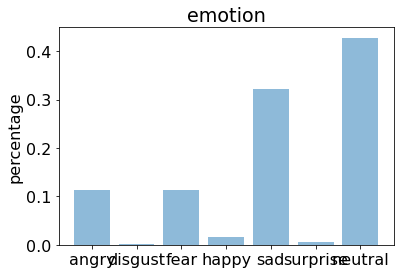

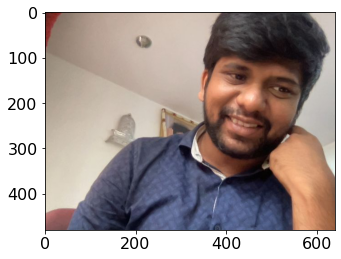

In [51]:
import cv2
            
def facecrop(image):  
    facedata = '/content/haarcascade_frontalface_alt.xml' 
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:
    
        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]

            
            cv2.imwrite('capture.jpg', sub_face)
            #print ("Writing: " + image)

    except Exception as e:
        print (e)

   


if __name__ == '__main__':
    facecrop('/content/photo.jpg')

#Testing a file.

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = '/content/photo.jpg'
true_image = image.load_img(file)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);


plt.imshow(true_image)
plt.show()
